In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/char_transformer

[Errno 2] No such file or directory: 'drive/MyDrive/char_transformer'
/content/drive/.shortcut-targets-by-id/1ZdikWibndOy-EAHWOwKrJSalwWRmsckp/char_transformer


In [ ]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# local imports
import models.models as models
import models.sinusoidal as models_sinusoidal
import util.generation as generation


In [ ]:
print("jax devices:", jax.devices())
print("device count:", jax.device_count())

jax devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]
device count: 1


In [ ]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [ ]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [ ]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [ ]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [ ]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

d at dresden by the elector of saxony and then going to england became in one seven five nine chamber musician to queen charlott

 she dismissed him in one six seven four von boineburg did much to promote leibniz s reputation and the latter s memoranda and l

 infection transportation bubonic plague is primarily a disease of rodents particularly marmots in which the most virulent strai

 pantonality a study of some trends in twentieth century music westport connecticut greenwood press isbn zero three one three tw

 married elector john sigismund of brandenburg who was granted the right of succession to ducal prussia on albert frederick s de



# Create a basic Transformer model

In [ ]:
def create_basic_transformer(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

def create_basic_transformer_sinusoidal_embedding(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    model = models_sinusoidal.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [ ]:
# vocab size
vocab_size = len(char_set)

# internal model dimensions
d_model=256

# number of attention heads
n_heads=8

# number of Transformer layers
n_layers=2

# maximum sequence length
max_len=128

model1, params1 = create_basic_transformer(key, vocab_size, d_model, n_layers, n_heads, max_len)
model2, params2 = create_basic_transformer_sinusoidal_embedding(key, vocab_size, d_model, n_layers, n_heads, max_len)

In [ ]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Model 1. Number of parameters: {count_params(params1):_}")
print(f"Model 2. Number of parameters: {count_params(params2):_}")

Model 1. Number of parameters: 1_624_576
Model 2. Number of parameters: 1_591_808


In [ ]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model1.apply({"params": params1}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

In [ ]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    # flat_logits = logits[:,-1, :]
    # flat_targets = targets[:,-1]
    # else:
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [ ]:
# create an update function
def train_step(params, opt_state, x, y, tx, model):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx", "model"))

# Batch creation:

In [ ]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [ ]:
# define optax optimizer
learning_rate = 0.001

# Create Adam optimizer (Optax)
tx1 = optax.adam(learning_rate=learning_rate)
tx2 = optax.adam(learning_rate=learning_rate)

# Initialize optimizer state for current params
opt_state1 = tx1.init(params1)
opt_state2 = tx2.init(params2)


In [ ]:
niter = 10_000
B, T = 128, 32
loss_history1 = []
time_history1 = []
time_test_history1 = []
loss_test_history1 = []
time_start = time.time()
for it in range(niter):
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params1, opt_stat1, metrics = train_step(params1, opt_state1, input, target, tx1, model1)

    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']

    loss_history1.append(loss)
    time_history1.append(time.time() - time_start)

    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start
        # compute loss on test set
        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model1.apply({"params": params1}, test_input)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
        test_acc = test_metrics['acc']
        test_acc_last = test_metrics['acc_last']
        loss_test_history1.append(test_loss)
        time_test_history1.append(time_since_start)
        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print()


iteration 0  time: 16.9 seconds
	 	 loss(train :: test): 3.9622 :: 3.5083
	 	 accuracy (train :: test): 2.2% :: 17.6%
	 	 accuracy (last character) (train :: test): 1.6% :: 17.4%

iteration 200  time: 19.4 seconds
	 	 loss(train :: test): 2.0519 :: 2.1171
	 	 accuracy (train :: test): 36.5% :: 35.0%
	 	 accuracy (last character) (train :: test): 39.1% :: 34.5%

iteration 400  time: 19.8 seconds
	 	 loss(train :: test): 1.8120 :: 1.8630
	 	 accuracy (train :: test): 44.0% :: 42.9%
	 	 accuracy (last character) (train :: test): 45.3% :: 43.5%

iteration 600  time: 20.2 seconds
	 	 loss(train :: test): 1.7570 :: 1.7417
	 	 accuracy (train :: test): 46.8% :: 46.8%
	 	 accuracy (last character) (train :: test): 46.9% :: 43.9%

iteration 800  time: 20.6 seconds
	 	 loss(train :: test): 1.6810 :: 1.6401
	 	 accuracy (train :: test): 49.5% :: 49.4%
	 	 accuracy (last character) (train :: test): 48.4% :: 48.2%

iteration 1_000  time: 21.0 seconds
	 	 loss(train :: test): 1.6196 :: 1.5876
	 	 ac

In [ ]:
loss_history2 = []
time_history2 = []
time_test_history2 = []
loss_test_history2 = []
time_start = time.time()
for it in range(niter):
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params2, opt_stat2, metrics = train_step(params2, opt_state2, input, target, tx2, model2)

    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']

    loss_history2.append(loss)
    time_history2.append(time.time() - time_start)

    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start
        # compute loss on test set
        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model2.apply({"params": params2}, test_input)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
        test_acc = test_metrics['acc']
        test_acc_last = test_metrics['acc_last']
        loss_test_history2.append(test_loss)
        time_test_history2.append(time_since_start)
        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print()


iteration 0  time: 17.4 seconds
	 	 loss(train :: test): 3.8125 :: 4.2367
	 	 accuracy (train :: test): 1.8% :: 17.1%
	 	 accuracy (last character) (train :: test): 1.6% :: 16.3%

iteration 200  time: 17.8 seconds
	 	 loss(train :: test): 2.6387 :: 2.5272
	 	 accuracy (train :: test): 23.5% :: 24.0%
	 	 accuracy (last character) (train :: test): 17.2% :: 22.9%

iteration 400  time: 18.2 seconds
	 	 loss(train :: test): 2.3115 :: 2.3409
	 	 accuracy (train :: test): 29.5% :: 29.7%
	 	 accuracy (last character) (train :: test): 28.1% :: 29.6%

iteration 600  time: 18.6 seconds
	 	 loss(train :: test): 2.2561 :: 2.2140
	 	 accuracy (train :: test): 32.0% :: 33.4%
	 	 accuracy (last character) (train :: test): 35.2% :: 35.2%

iteration 800  time: 19.0 seconds
	 	 loss(train :: test): 2.1231 :: 2.1126
	 	 accuracy (train :: test): 34.9% :: 35.3%
	 	 accuracy (last character) (train :: test): 28.1% :: 34.6%

iteration 1_000  time: 19.4 seconds
	 	 loss(train :: test): 2.0667 :: 2.0339
	 	 ac

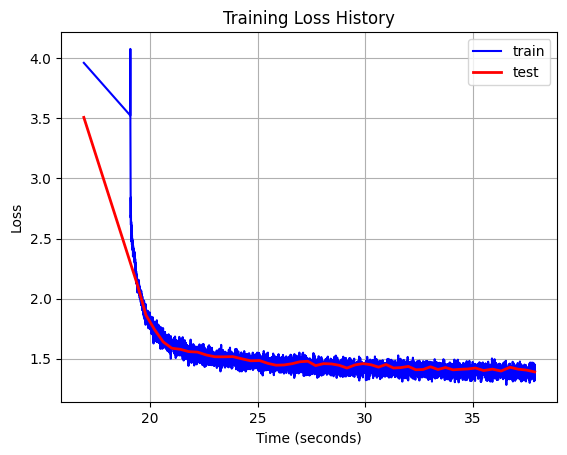

In [ ]:
# plot the loss history
import matplotlib.pyplot as plt

plt.plot(time_history1, loss_history1, '-', label='train', color="blue")
plt.plot(time_test_history1, loss_test_history1, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

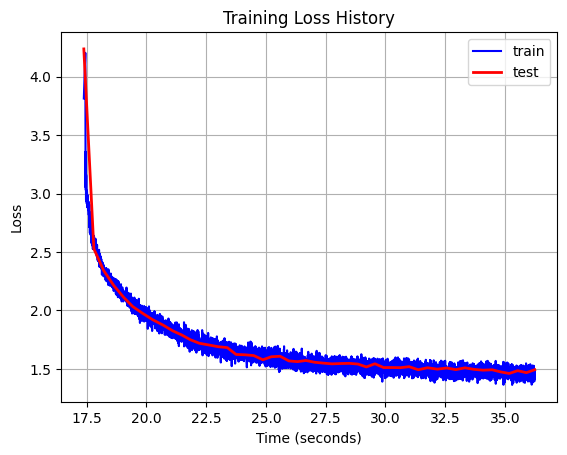

In [ ]:
plt.plot(time_history2, loss_history2, '-', label='train', color="blue")
plt.plot(time_test_history2, loss_test_history2, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

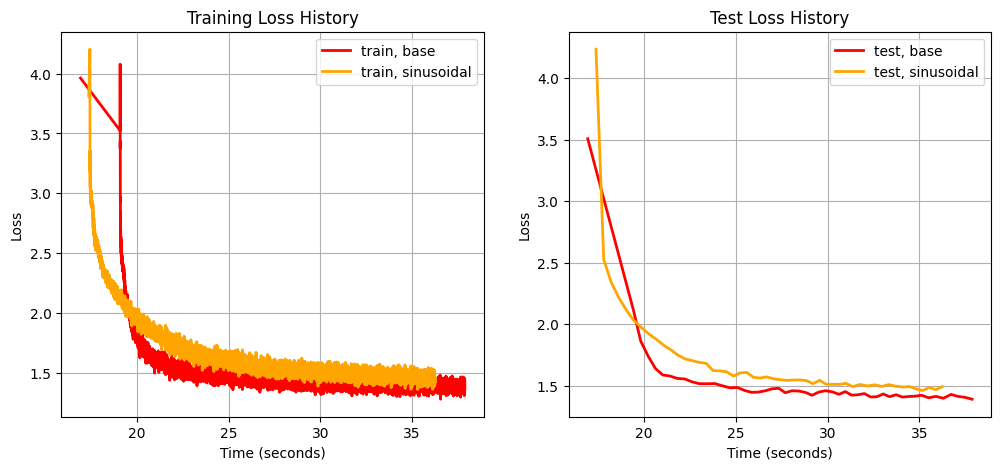

In [ ]:
plt.figure(figsize=(12, 5))


# Compare test loss 1 with test loss 2 on seconds
plt.subplot(1, 2, 1)
plt.plot(time_history1, loss_history1, '-', label='train, base', lw=2, color="red")
plt.plot(time_history2, loss_history2, '-', label='train, sinusoidal', lw=2, color="orange")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

# Compare train loss 1 with train loss 2 on seconds
plt.subplot(1, 2, 2)
plt.plot(time_test_history1, loss_test_history1, '-', label='test, base', lw=2, color="red")
plt.plot(time_test_history2, loss_test_history2, '-', label='test, sinusoidal', lw=2, color="orange")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Test Loss History")
plt.grid()



In [ ]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"
# prompt_int = encode(prompt.lower())
prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)

gen_len = 1000
out_ids = generation.generate_tokens(model1, params1, rng, prompt_int, gen_len, block_size=64,
                          temperature=0.7, sample=True)
print('generated ids shape:', out_ids.shape)
print('generated text:')
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# concatenate with prompt
print(prompt + generated_text)
#print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

generated ids shape: (1, 1000)
generated text:
hello my fri il ste ido as a o sh aimanonedongine manenesherpane chours choloriamas s wichouman moneste e wargises asthas s ghon dris ar kigoush ighames whas s teschase fe anitare ts arugre chasthast bononitrianene oples chatharinisthrp ne d phe icop ciz w tes phcoles arge f w dronopone s threm tisit cabrge re chous canone s eranesthalous resineseseddlinamasphone s iases t sphphesiam a ches ase ononor f thererarsiare asigat edithone be w forime im ca ach arnoparedanelaresithanes lisinoborthe on iar ash es te boribanghonsh arig ofinecherigrithesth aristh w onounonicar an r s s ghatistine with t cangritharele igry is ichinoune cheshes es in anoseane aramisiseanowlahadiga tear miars alids thian orar ca ckonesp ffaninonine s inithestitacke blatrghanghest t twhes hes caner as ws w p th teneren t adrenewis case twepof conigharorane dours ano asy ot sthesesth th bamesthoushmithalorinorin d irs p owhrimeded ch a es te te twanonotwhe is in woponire